In [1]:
import os

In [4]:
!pip install peft accelerate rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=4c46e1f0a8c1cada180a969f8c3b8c2f83b2056ffc305c75a5233d32a1c68b59
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


In [5]:
import os
import matplotlib.pyplot as plt
import transformers
from transformers import AutoModelForCausalLM, AutoTokenizer, TrainingArguments, Trainer
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from peft import get_peft_model, LoraConfig, TaskType
from accelerate import FullyShardedDataParallelPlugin, Accelerator
from torch.distributed.fsdp.fully_sharded_data_parallel import FullOptimStateDictConfig, FullStateDictConfig

In [6]:

# Custom Dataset Class
class TextDataset(Dataset):
    def __init__(self, tokenizer, source_texts, target_texts, max_length=512):
        self.tokenizer = tokenizer
        self.source_texts = source_texts
        self.target_texts = target_texts
        self.max_length = max_length

    def __len__(self):
        return len(self.source_texts)

    def __getitem__(self, idx):
        source = self.source_texts[idx]
        target = self.target_texts[idx]
        inputs = self.tokenizer(source, max_length=self.max_length, padding='max_length', truncation=True, return_tensors='pt')
        labels = self.tokenizer(target, max_length=self.max_length, padding='max_length', truncation=True, return_tensors='pt')
        input_ids = inputs.input_ids.squeeze()
        attention_mask = inputs.attention_mask.squeeze()
        labels = labels.input_ids.squeeze()
        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': labels
        }


In [7]:
device = torch.device("mps") if torch.backends.mps.is_available() else "cpu"


In [8]:

# Load Model and Tokenizer
save_name = 'models/phi-2-lora'
model_name = 'microsoft/phi-2'
model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.float16, trust_remote_code=True)
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)

tokenizer.pad_token = tokenizer.eos_token


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/735 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/35.7k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/564M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/7.34k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

In [9]:
model.to(device)

PhiForCausalLM(
  (model): PhiModel(
    (embed_tokens): Embedding(51200, 2560)
    (embed_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-31): 32 x PhiDecoderLayer(
        (self_attn): PhiSdpaAttention(
          (q_proj): Linear(in_features=2560, out_features=2560, bias=True)
          (k_proj): Linear(in_features=2560, out_features=2560, bias=True)
          (v_proj): Linear(in_features=2560, out_features=2560, bias=True)
          (dense): Linear(in_features=2560, out_features=2560, bias=True)
          (rotary_emb): PhiRotaryEmbedding()
        )
        (mlp): PhiMLP(
          (activation_fn): NewGELUActivation()
          (fc1): Linear(in_features=2560, out_features=10240, bias=True)
          (fc2): Linear(in_features=10240, out_features=2560, bias=True)
        )
        (input_layernorm): LayerNorm((2560,), eps=1e-05, elementwise_affine=True)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (final_layernorm): LayerNorm((256

In [10]:

# Configure LoRA with PEFT
lora_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,  # Set the task type for causal language models
    r=8,  # LoRA rank
    lora_alpha=16,  # Scaling factor
    lora_dropout=0.05,  # Dropout probability for LoRA layers
    target_modules=["Wqkv", "fc1", "fc2"],  # Target layers to apply LoRA
)

# Apply LoRA to the model
model = get_peft_model(model, lora_config)

In [11]:

# Set up Accelerator for distributed training
fsdp_plugin = FullyShardedDataParallelPlugin(
    state_dict_config=FullStateDictConfig(offload_to_cpu=True, rank0_only=False),
    optim_state_dict_config=FullOptimStateDictConfig(offload_to_cpu=True, rank0_only=False),
)
accelerator = Accelerator(fsdp_plugin=fsdp_plugin)

# Prepare model with accelerator
model = accelerator.prepare_model(model)

In [12]:

# Check if MPS or CUDA is available for GPU acceleration
if torch.backends.mps.is_available():
    device = torch.device("mps")  # Use MPS (Metal Performance Shaders) on Apple Silicon
elif torch.cuda.is_available():
    device = torch.device("cuda")  # Use CUDA if available
else:
    device = torch.device("cpu")  # Fallback to CPU if neither is available

model.to(device)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): PhiForCausalLM(
      (model): PhiModel(
        (embed_tokens): Embedding(51200, 2560)
        (embed_dropout): Dropout(p=0.0, inplace=False)
        (layers): ModuleList(
          (0-31): 32 x PhiDecoderLayer(
            (self_attn): PhiSdpaAttention(
              (q_proj): Linear(in_features=2560, out_features=2560, bias=True)
              (k_proj): Linear(in_features=2560, out_features=2560, bias=True)
              (v_proj): Linear(in_features=2560, out_features=2560, bias=True)
              (dense): Linear(in_features=2560, out_features=2560, bias=True)
              (rotary_emb): PhiRotaryEmbedding()
            )
            (mlp): PhiMLP(
              (activation_fn): NewGELUActivation()
              (fc1): lora.Linear(
                (base_layer): Linear(in_features=2560, out_features=10240, bias=True)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
  

In [13]:
device

device(type='cuda')

In [14]:

# Load dataset and split into train and validation
full_data = pd.read_csv("hf://datasets/s-nlp/paradetox/train.tsv", sep="\t").sample(1000, random_state=42)
train_data, val_data = train_test_split(full_data, test_size=0.1, random_state=42)


In [15]:
len(train_data), len(val_data)

(900, 100)

In [16]:

# Prepare datasets
train_dataset = TextDataset(tokenizer, train_data["en_toxic_comment"].tolist(), train_data["en_neutral_comment"].tolist())
val_dataset = TextDataset(tokenizer, val_data["en_toxic_comment"].tolist(), val_data["en_neutral_comment"].tolist())


In [17]:

# Training arguments
training_args = TrainingArguments(
    logging_steps=10,  # Set logging frequency to be more verbose
    logging_first_step=True,  # Log the first step to see immediate progress
    log_level='info',  # Set log level to info to see more detailed logs
    output_dir=save_name,
    num_train_epochs=3,
    per_device_train_batch_size=1,
    gradient_accumulation_steps=4,
    max_steps=500,
    learning_rate=2.5e-5,
    warmup_steps=5,
    weight_decay=0.01,
    logging_dir='./logs',
    evaluation_strategy='steps',
    save_strategy='steps',
    save_steps=50,
    eval_steps=50,
    do_eval=True,
    load_best_model_at_end=True,
    optim="adamw_torch",
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [18]:
# Trainer setup
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

max_steps is given, it will override any value given in num_train_epochs


In [19]:
trainer.train()


***** Running training *****
  Num examples = 900
  Num Epochs = 3
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 4
  Total optimization steps = 500
  Number of trainable parameters = 6,553,600


Step,Training Loss,Validation Loss
50,5.611600,5.194396
100,4.656800,4.656124
150,4.497100,4.491778
200,4.682500,4.419750
250,4.684100,4.379022
300,4.468500,4.351752
350,4.469600,4.329660
400,4.436100,4.317003
450,4.264100,4.311016
500,4.230600,4.309539



***** Running Evaluation *****
  Num examples = 100
  Batch size = 8
We detected that you are passing `past_key_values` as a tuple and this is deprecated and will be removed in v4.43. Please use an appropriate `Cache` class (https://huggingface.co/docs/transformers/v4.41.3/en/internal/generation_utils#transformers.Cache)
Saving model checkpoint to models/phi-2-lora/checkpoint-50
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--microsoft--phi-2/snapshots/ef382358ec9e382308935a992d908de099b64c23/config.json
Model config PhiConfig {
  "_name_or_path": "microsoft/phi-2",
  "architectures": [
    "PhiForCausalLM"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 50256,
  "embd_pdrop": 0.0,
  "eos_token_id": 50256,
  "hidden_act": "gelu_new",
  "hidden_size": 2560,
  "initializer_range": 0.02,
  "intermediate_size": 10240,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 2048,
  "model_type": "phi",
  "num_attention_heads": 32,
  "num_hidden_

TrainOutput(global_step=500, training_loss=4.62711489200592, metrics={'train_runtime': 1047.3093, 'train_samples_per_second': 1.91, 'train_steps_per_second': 0.477, 'total_flos': 1.631333646336e+16, 'train_loss': 4.62711489200592, 'epoch': 2.2222222222222223})

In [25]:
# Print training logs
trainer.state.log_history

[{'loss': 5.1495,
  'grad_norm': 1.1620521545410156,
  'learning_rate': 5e-06,
  'epoch': 0.0044444444444444444,
  'step': 1},
 {'loss': 5.8838,
  'grad_norm': 1.2391808032989502,
  'learning_rate': 2.474747474747475e-05,
  'epoch': 0.044444444444444446,
  'step': 10},
 {'loss': 5.8275,
  'grad_norm': 1.8257901668548584,
  'learning_rate': 2.4242424242424244e-05,
  'epoch': 0.08888888888888889,
  'step': 20},
 {'loss': 5.5357,
  'grad_norm': 2.6363348960876465,
  'learning_rate': 2.3737373737373738e-05,
  'epoch': 0.13333333333333333,
  'step': 30},
 {'loss': 5.7998,
  'grad_norm': 3.5885891914367676,
  'learning_rate': 2.3232323232323232e-05,
  'epoch': 0.17777777777777778,
  'step': 40},
 {'loss': 5.6116,
  'grad_norm': 4.230369567871094,
  'learning_rate': 2.272727272727273e-05,
  'epoch': 0.2222222222222222,
  'step': 50},
 {'eval_loss': 5.194395542144775,
  'eval_runtime': 17.6108,
  'eval_samples_per_second': 5.678,
  'eval_steps_per_second': 0.738,
  'epoch': 0.2222222222222222,

In [26]:
from tabulate import tabulate

In [22]:

# Evaluate the model
eval_results = trainer.evaluate()



***** Running Evaluation *****
  Num examples = 100
  Batch size = 8


In [24]:

# Print evaluation logs
trainer.state.log_history
print("Evaluation Results:", eval_results)

Evaluation Results: {'eval_loss': 4.309539318084717, 'eval_runtime': 18.4247, 'eval_samples_per_second': 5.428, 'eval_steps_per_second': 0.706, 'epoch': 2.2222222222222223}


In [28]:

# Load test data
x_test = tokenizer(val_data["en_toxic_comment"].tolist(), return_tensors="pt", truncation=True, padding=True)
y_test = val_data["en_neutral_comment"].tolist()

# Move inputs to device
x_test = {k: v.to(device) for k, v in x_test.items()}

# Make predictions
model.eval()
predictions = []
for i in range(len(x_test["input_ids"])):
    inputs = {k: v[i:i+1] for k, v in x_test.items()}  # Select one example at a time
    output = model.generate(**inputs, num_return_sequences=1, do_sample=False, num_beams=5, max_new_tokens = 50)
    prediction = tokenizer.decode(output[0], skip_special_tokens=True)
    predictions.append(prediction)


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

In [30]:

# Evaluate using BLEU and ROUGE
references = [ref.split() for ref in y_test]  # Convert references to list of tokens
predictions_split = [pred.split() for pred in predictions]

# BLEU Score Calculation
bleu_scores = [sentence_bleu([ref], pred) for ref, pred in zip(references, predictions_split)]
average_bleu_score = sum(bleu_scores) / len(bleu_scores)

# ROUGE Score Calculation
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
rouge_scores = [scorer.score(ref, pred) for ref, pred in zip(y_test, predictions)]

average_rouge_score = {
    "rouge1": sum([score['rouge1'].fmeasure for score in rouge_scores]) / len(rouge_scores),
    "rouge2": sum([score['rouge2'].fmeasure for score in rouge_scores]) / len(rouge_scores),
    "rougeL": sum([score['rougeL'].fmeasure for score in rouge_scores]) / len(rouge_scores)
}

print("Average BLEU Score:", average_bleu_score)
print("Average ROUGE Scores:", average_rouge_score)

Average BLEU Score: 0.20516842211027733
Average ROUGE Scores: {'rouge1': 0.5720875429370404, 'rouge2': 0.43382047173301463, 'rougeL': 0.5632892403519731}


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

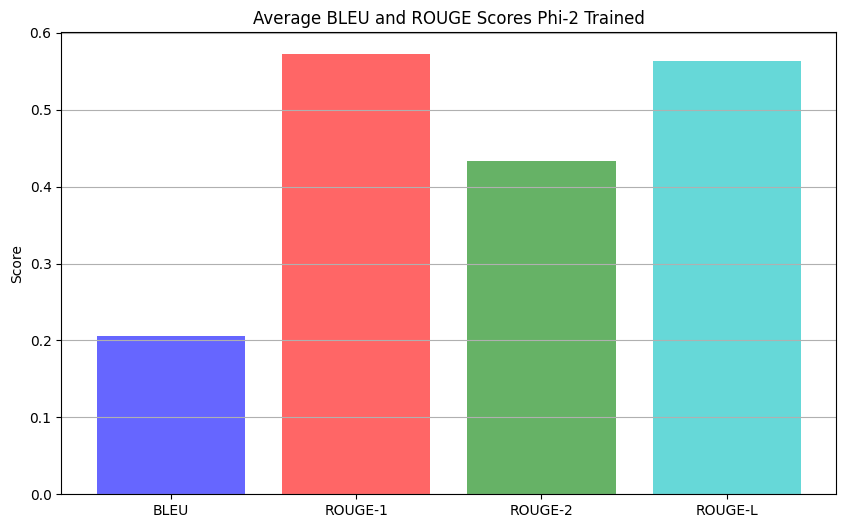

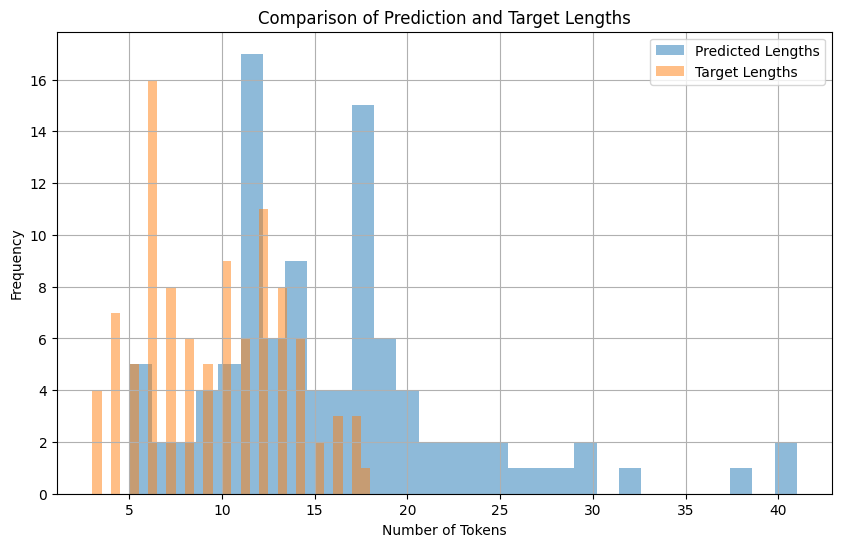

In [31]:

# Plotting Average Scores
plt.figure(figsize=(10, 6))

# Plotting Average BLEU Score
plt.bar(['BLEU'], [average_bleu_score], color='b', alpha=0.6)

# Plotting Average ROUGE Scores
rouge_labels = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L']
rouge_values = [average_rouge_score['rouge1'], average_rouge_score['rouge2'], average_rouge_score['rougeL']]
plt.bar(rouge_labels, rouge_values, color=['r', 'g', 'c'], alpha=0.6)

plt.ylabel('Score')
plt.title('Average BLEU and ROUGE Scores Phi-2 Trained')
plt.grid(axis='y')
plt.show()

# Additional Graph: Prediction Lengths vs Target Lengths
pred_lengths = [len(p.split()) for p in predictions]
target_lengths = [len(t.split()) for t in y_test]

plt.figure(figsize=(10, 6))
plt.hist(pred_lengths, alpha=0.5, bins=30, label='Predicted Lengths')
plt.hist(target_lengths, alpha=0.5, bins=30, label='Target Lengths')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.title('Comparison of Prediction and Target Lengths')
plt.legend()
plt.grid(True)
plt.show()

In [32]:

# Create a table for the scores
table_data = [
    ["Metric", "Score"],
    ["BLEU", average_bleu_score],
    ["ROUGE-1", average_rouge_score['rouge1']],
    ["ROUGE-2", average_rouge_score['rouge2']],
    ["ROUGE-L", average_rouge_score['rougeL']]
]

In [33]:
print("Phi-2 Trained")
print(tabulate(table_data, headers="firstrow", tablefmt="pretty"))


Phi-2 Trained
+---------+---------------------+
| Metric  |        Score        |
+---------+---------------------+
|  BLEU   | 0.20516842211027733 |
| ROUGE-1 | 0.5720875429370404  |
| ROUGE-2 | 0.43382047173301463 |
| ROUGE-L | 0.5632892403519731  |
+---------+---------------------+


In [36]:
sample_data = {
    'Input': val_data['en_toxic_comment'].iloc[:5].tolist(),
    'Prediction': predictions[:5],
    'Ground Truth': y_test[:5]
}
sample_df = pd.DataFrame(sample_data)
print(tabulate(sample_df, headers='keys', tablefmt='pretty'))

+---+-----------------------------------------------------------------------------------------+------------------------------------------------------------------------------+-------------------------------------------------------------------+
|   |                                          Input                                          |                                  Prediction                                  |                           Ground Truth                            |
+---+-----------------------------------------------------------------------------------------+------------------------------------------------------------------------------+-------------------------------------------------------------------+
| 0 |                hahaha that was so funny ! major lick ass alerttopstalker                |                     haha that was so funny! major talker                     |        hahaha that was so funny ! major alert tops talker         |
| 1 | who in their right min